In [29]:
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, GlobalAveragePooling1D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras import Input
from keras.callbacks import EarlyStopping

import pandas as pdm
import matplotlib.pyplot as plt

import os
import glob
import copy

## Loading the data

In [2]:
data_dir = 'PTT_data/csv/'

# return a list of all csv files in dir
csv_files = glob.glob(os.path.join(data_dir,'*.csv'))

# list to hold dataframes
dfs = []

for file in csv_files:
    basename = os.path.basename(file)                              # extract just the filename from path
    subject, activity = basename.replace('.csv','').split('_')

    df = pd.read_csv(file)

    # adding subject and acitivity feature to the column
    df['subject'] = subject
    df['activity'] = activity

    dfs.append(df)

data = pd.concat(dfs, ignore_index = True)

In [3]:
print(data.head())
print(data['subject'].unique())
print(data['activity'].unique())

                         time    ecg  peaks  pleth_1  pleth_2  pleth_3  \
0  2021-01-01 11:43:07.015594  31452      0    66594    80015     3932   
1  2021-01-01 11:43:07.017594  31311      0    66592    80017     3930   
2  2021-01-01 11:43:07.019594  31307      0    66594    80010     3927   
3  2021-01-01 11:43:07.021594  31352      0    66594    80010     3927   
4  2021-01-01 11:43:07.023594  31462      0    66601    80019     3936   

   pleth_4  pleth_5  pleth_6     lc_1  ...  temp_2     temp_3       a_x  \
0    68510    93507     3747  6355463  ...   31.81  31.863510  9.260646   
1    68508    93503     3740  6355463  ...   31.81  31.863510  9.240892   
2    68513    93501     3743  6355463  ...   31.81  31.860516  9.214555   
3    68510    93504     3743  6355463  ...   31.81  31.857519  9.198992   
4    68505    93506     3751  6355463  ...   31.81  31.857519  9.185822   

        a_y       a_z       g_x       g_y       g_z  subject  activity  
0 -2.409288  2.903117  0.304216

In [4]:
print(len(data))

16217132


In [5]:
# converting the labels to have numeric values for the model training pipeline (encoding)
activity_map = {'sit': 0, 'walk': 1, 'run': 2}
data['activity_label'] = data['activity'].map(activity_map)

In [6]:
# keeping only required features and droping everything else
keep_cols = ['time', 'ecg', 'peaks', 'pleth_3','subject','activity_label']
cols_to_drop = [col for col in data.columns if col not in keep_cols]

data.drop(columns=cols_to_drop, inplace=True)

In [7]:
print(data.head())

                         time    ecg  peaks  pleth_3 subject  activity_label
0  2021-01-01 11:43:07.015594  31452      0     3932      s9               1
1  2021-01-01 11:43:07.017594  31311      0     3930      s9               1
2  2021-01-01 11:43:07.019594  31307      0     3927      s9               1
3  2021-01-01 11:43:07.021594  31352      0     3927      s9               1
4  2021-01-01 11:43:07.023594  31462      0     3936      s9               1


In [8]:
print(len(data))

16217132


## Viewing the signal
This is done to ensure that the data is continous 

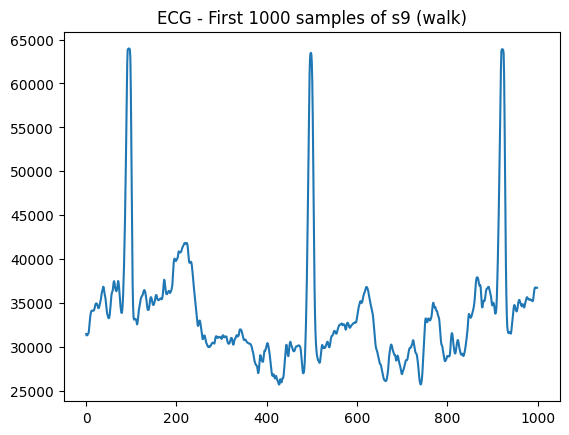

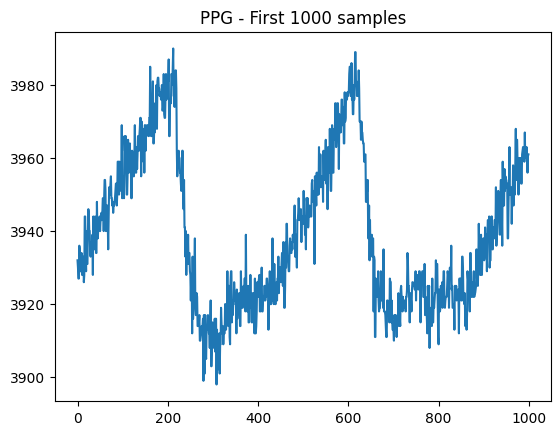

In [9]:
# For subject 's9' and activity 'walk'
single_subject = data[(data['subject'] == 's9') & (data['activity_label'] == 1)]  # 1 == walk

plt.plot(single_subject['ecg'][:1000])
plt.title('ECG - First 1000 samples of s9 (walk)')
plt.show()

plt.plot(single_subject['pleth_3'][:1000])
plt.title('PPG - First 1000 samples')
plt.show()


## Filtering signal
Removing noise and baseline wander, motiion artifacts and electrical interference

Remember,<br>
Nyquist Frequency f_max = 2*sampling_frequency

In [10]:
# butterworth bandpass filter
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

fs = 500
data['ecg_filt'] = bandpass_filter(data['ecg'], 0.5, 40, fs)
data['ppg_filt'] = bandpass_filter(data['pleth_3'], 0.5, 8, fs)

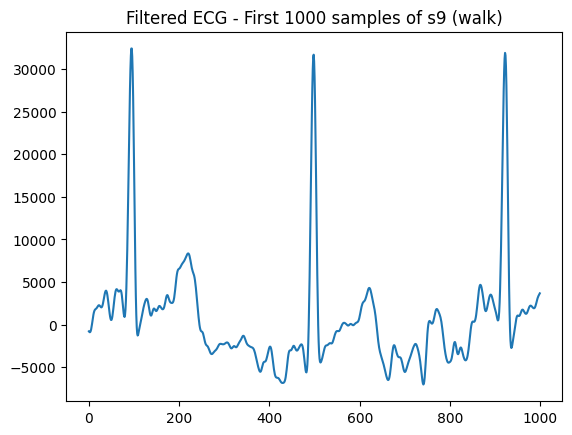

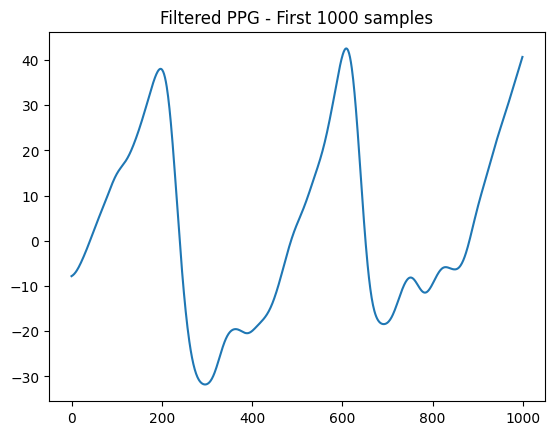

In [11]:
single_subject = data[(data['subject'] == 's9') & (data['activity_label'] == 1)]  # 1 == walk

plt.plot(single_subject['ecg_filt'][:1000])
plt.title('Filtered ECG - First 1000 samples of s9 (walk)')
plt.show()

plt.plot(single_subject['ppg_filt'][:1000])
plt.title('Filtered PPG - First 1000 samples')
plt.show()

In [12]:
cols_to_drop = ['ecg','pleth_3']

data.drop(columns=cols_to_drop, inplace=True)

In [13]:
print(data.head())

                         time  peaks subject  activity_label    ecg_filt  \
0  2021-01-01 11:43:07.015594      0      s9               1 -792.186566   
1  2021-01-01 11:43:07.017594      0      s9               1 -864.083334   
2  2021-01-01 11:43:07.019594      0      s9               1 -900.673758   
3  2021-01-01 11:43:07.021594      0      s9               1 -872.151555   
4  2021-01-01 11:43:07.023594      0      s9               1 -758.615600   

   ppg_filt  
0 -7.815380  
1 -7.756085  
2 -7.688067  
3 -7.611171  
4 -7.525283  


In [14]:
print(len(data))

16217132


## Creating Time segments
Since the data is recorded in continous time and our CNN model can only take in data in form of segmented fixed lenght inputs we need to sort this out. Here it is done by forming windows of fixed length to capture the continous time in segments and then feed it into our CNN model.

This continous form of data in time is called Time-series data

In [21]:
import numpy as np

def create_windows(data, window_size, stride):
    """
    Creates sliding windows from the filtered ECG and PPG signals in a DataFrame.

    Args:
        data (pd.DataFrame): DataFrame containing filtered signals for a single recording.
        window_size (int): The number of samples in each window.
        stride (int): The step size for the sliding window.

    Returns:
        np.array: An array of windowed segments, shape (num_windows, window_size, 2).
        np.array: An array of labels for each window.
    """
    segments = []    # stores all new created signal windows
    labels = []      # stores the label of that corresponding window on the same index 

    # Extracting the signal values as raw NumPy arrays since it makes numerical operations faster
    ecg_signal = data['ecg_filt'].values
    ppg_signal = data['ppg_filt'].values
    activity_labels = data['activity_label'].values

    # Slide the window across the signals and the last possible window will be length of eccg signals - window size and + 1 so that the last value is included in loop
    for start_idx in range(0, len(ecg_signal) - window_size + 1, stride):
        end_idx = start_idx + window_size
        
        # Extract the window from both signals
        ecg_window = ecg_signal[start_idx:end_idx]
        ppg_window = ppg_signal[start_idx:end_idx]

        # Combining the ECG and PPG windows into a single 2-channel segment
        # The shape will be (window_size, 2) i.e into column vectors
        segment = np.stack([ecg_window, ppg_window], axis=1)
        segments.append(segment)

        # Assigning a label to the window. Taking the label at the start is simple and effective.
        labels.append(activity_labels[start_idx])

    return np.array(segments), np.array(labels)

In [22]:
# Defining  hyper-parameters
fs = 500  # The sampling frequency
window_seconds = 5
stride_seconds = 2.5 # 50% overlap

window_size = int(window_seconds * fs) # 2500 samples
stride = int(stride_seconds * fs)      # 1250 samples

# Process data for each subject and activity combination
all_segments = []
all_labels = []

# spliting the dataframe into smaller dataframes for each unique comnination of specified columns
for (subject, activity), group in data.groupby(['subject', 'activity_label']):
    print(f"Processing Subject: {subject}, Activity: {activity}...")
    
    # Create windows for this specific group
    segments, labels = create_windows(group, window_size, stride)

    # safety check to ensure that if recording length was too short and not even a single full window is formed then empty segment list is not appended
    if len(segments) > 0:
        all_segments.append(segments)
        all_labels.append(labels)

# Combine all windows into a single dataset
X = np.concatenate(all_segments)
y = np.concatenate(all_labels)

# Check the final shape of your dataset
print("\n--- Final Dataset Shapes ---")
print(f"Features (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")

Processing Subject: s1, Activity: 0...
Processing Subject: s1, Activity: 1...
Processing Subject: s1, Activity: 2...
Processing Subject: s10, Activity: 0...
Processing Subject: s10, Activity: 1...
Processing Subject: s10, Activity: 2...
Processing Subject: s11, Activity: 0...
Processing Subject: s11, Activity: 1...
Processing Subject: s11, Activity: 2...
Processing Subject: s12, Activity: 0...
Processing Subject: s12, Activity: 1...
Processing Subject: s12, Activity: 2...
Processing Subject: s13, Activity: 0...
Processing Subject: s13, Activity: 1...
Processing Subject: s13, Activity: 2...
Processing Subject: s14, Activity: 0...
Processing Subject: s14, Activity: 1...
Processing Subject: s14, Activity: 2...
Processing Subject: s15, Activity: 0...
Processing Subject: s15, Activity: 1...
Processing Subject: s15, Activity: 2...
Processing Subject: s16, Activity: 0...
Processing Subject: s16, Activity: 1...
Processing Subject: s16, Activity: 2...
Processing Subject: s17, Activity: 0...
Pro

There are 12871 traning examples with each training example having 2500 samples in it of 2 columns ECG and PPG

In [23]:
print(# View the first 5 segments
print(X[:5]))

[[[-2.16482717e+03 -7.32508268e+00]
  [-2.05583260e+03  3.23420883e+01]
  [-1.95440489e+03  7.16610945e+01]
  ...
  [ 1.29480509e+03  2.79243098e+00]
  [ 1.49731313e+03  2.85596376e+00]
  [ 1.70093419e+03  2.91517467e+00]]

 [[ 1.79555071e+03  1.18085269e+01]
  [ 1.97680102e+03  1.18753980e+01]
  [ 2.12850010e+03  1.19304784e+01]
  ...
  [ 2.01984740e+03 -1.80992029e+00]
  [ 2.15628416e+03 -1.78827484e+00]
  [ 2.27739068e+03 -1.76491216e+00]]

 [[ 1.89799844e+03  2.97047429e+00]
  [ 2.08164905e+03  3.02228070e+00]
  [ 2.24680245e+03  3.07101454e+00]
  ...
  [-1.42685713e+03  4.85470147e+00]
  [-1.50675818e+03  4.94970764e+00]
  [-1.56289924e+03  5.03980154e+00]]

 [[ 2.37885117e+03 -1.73895539e+00]
  [ 2.45204549e+03 -1.70955849e+00]
  [ 2.48431630e+03 -1.67591617e+00]
  ...
  [ 2.26805437e+01  1.06562159e+01]
  [ 1.67538921e+02  1.01762436e+01]
  [ 3.11560863e+02  9.66539812e+00]]

 [[-1.59939643e+03  5.12462070e+00]
  [-1.62091025e+03  5.20383391e+00]
  [-1.63237965e+03  5.27714573e+

## Normalizing dataset
Also in a Physiological Time-Series data we perform noramllizing by finding the mean and std deviation of each window or time segment instead of finding the global mean and std deviation since these physiological signals are non-stationary and would vary with each subject and their movement

In [25]:
X_normalized = np.copy(X)

# Iterate through each window in dataset
for i in range(X.shape[0]):
    # Calculate mean and std for the current window
    mean = np.mean(X[i], axis=0)  # axis=0 calculates mean down the columns
    std = np.std(X[i], axis=0)
    
    # Apply z-score normalization
    # Adding a small epsilon to avoid division by zero if a window has zero std
    X_normalized[i] = (X[i] - mean) / (std + 1e-8)

print(X_normalized[:5])

[[[-0.43645022 -0.29387569]
  [-0.41378783  0.07469124]
  [-0.39269876  0.44002321]
  ...
  [ 0.28288393 -0.19986897]
  [ 0.32498984 -0.19927865]
  [ 0.36732716 -0.19872849]]

 [[ 0.37385847  1.41448131]
  [ 0.41103795  1.42227855]
  [ 0.44215564  1.42870098]
  ...
  [ 0.41986795 -0.17344383]
  [ 0.44785492 -0.17091995]
  [ 0.47269723 -0.16819583]]

 [[ 0.38329461  0.32379032]
  [ 0.42081932  0.32948697]
  [ 0.45456456  0.33484577]
  ...
  [-0.29606191  0.53098081]
  [-0.31238782  0.54142773]
  [-0.32385893  0.5513345 ]]

 [[ 0.47076592 -0.29909224]
  [ 0.48468778 -0.29538823]
  [ 0.49082582 -0.29114928]
  ...
  [ 0.02261252  1.26270277]
  [ 0.05016518  1.20222612]
  [ 0.07755875  1.13785945]]

 [[-0.32129735  0.59827709]
  [-0.3252915   0.60861002]
  [-0.32742085  0.61817316]
  ...
  [ 1.16918934 -1.16319615]
  [ 1.12440613 -1.23683   ]
  [ 1.07096183 -1.30706208]]]


## Data Split

In [27]:
# stratify = y; ensures that the proportion of each activity is the same in both sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (10296, 2500, 2), (10296,)
Validation set shape: (1287, 2500, 2), (1287,)
Test set shape: (1288, 2500, 2), (1288,)


## Building the modelm
GlobalAveragePooling is added instead of just using MaxPooling layer to get rid of the time dependencies or dimensions (not referring to a column with dates or times but to the sequence and order of the samples within each window) since our dense or the final classification layer is time-unaware and expects only features

Time dimension eg in our second dimension of shape we have 2500 and it is a consecutive measurement taken is specific order hence the fact that sample i comes before i+1 and if we were to shuffle this the ecg and ppg waveforms will be destroyed

In [51]:
# Get the input shape directly from training data, this makes code robust and adaptable to different window sizes.
input_shape = (X_train.shape[1], X_train.shape[2]) 

# Determine the number of unique activity classes from your labels.
num_classes = len(np.unique(y_train)) 

In [52]:
# Model Architechture

model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])


print("--- 1D-CNN Model Summary ---")
model.summary()

--- 1D-CNN Model Summary ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 2496, 32)       │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1248, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 1244, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 622, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 618, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 309, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 309, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,003 (148.45 KB)

 Trainable params: 38,003 (148.45 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
early_stop = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,                 # Stop after 10 epochs with no improvement
    min_delta=0.01,           # Minimum change to count as improvement
    mode='min',                # Minimize the monitored metric
    restore_best_weights=True, # Restore weights from best epoch
    verbose=1                  # Print when stopping occurs
)

## Model Training

In [55]:
history = model.fit(
    np.array(X_train), np.array(y_train), 
    batch_size=32,
    epochs=250,
    validation_data=(np.array(X_val), np.array(y_val)),
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/250
322/322 - 23s - 73ms/step - accuracy: 0.5285 - loss: 0.8973 - val_accuracy: 0.6224 - val_loss: 0.7654
Epoch 2/250
322/322 - 20s - 63ms/step - accuracy: 0.5968 - loss: 0.7702 - val_accuracy: 0.6309 - val_loss: 0.6821
Epoch 3/250
322/322 - 20s - 63ms/step - accuracy: 0.6212 - loss: 0.7294 - val_accuracy: 0.6558 - val_loss: 0.6801
Epoch 4/250
322/322 - 20s - 63ms/step - accuracy: 0.6428 - loss: 0.6955 - val_accuracy: 0.6472 - val_loss: 0.6802
Epoch 5/250
322/322 - 20s - 63ms/step - accuracy: 0.6618 - loss: 0.6662 - val_accuracy: 0.6970 - val_loss: 0.6071
Epoch 6/250
322/322 - 20s - 63ms/step - accuracy: 0.6873 - loss: 0.6324 - val_accuracy: 0.7063 - val_loss: 0.6002
Epoch 7/250
322/322 - 20s - 63ms/step - accuracy: 0.6951 - loss: 0.6192 - val_accuracy: 0.6970 - val_loss: 0.6105
Epoch 8/250
322/322 - 20s - 63ms/step - accuracy: 0.7210 - loss: 0.5798 - val_accuracy: 0.7296 - val_loss: 0.5283
Epoch 9/250
322/322 - 20s - 63ms/step - accuracy: 0.7331 - loss: 0.5608 - val_accuracy: 

In [56]:
print("\n--- Evaluating Final Model on Test Set ---")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print("\n" + "-"*50)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")
print("-"*50)


--- Evaluating Final Model on Test Set ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9115 - loss: 0.1977

--------------------------------------------------
Final Test Accuracy: 91.15%
Final Test Loss: 0.1977
--------------------------------------------------
